In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-review-data-set/amazon_review.csv


# Business Problem

One of the most important problems in e-commerce is the correct calculation of the points given to the products after the sale. The solution to this problem is providing more customer satisfaction for the e-commerce site, making the product stand out for the sellers and a seamless shopping experience for the buyers. Another problem is the correct ordering of the comments given to the products. Since misleading comments will directly affect the sale of the product, it will cause both material loss and loss of customers. When these 2 main problems are solved, e-commerce site and sellers will increase their sales, while their customers will complete the purchasing journey without any problems.

This dataset, which includes Amazon product data, includes product categories and various metadata. The product with the most reviews in the electronics category has user ratings and reviews.


Variables <br/>
* reviewerID: User ID  <br/>
* asin : Product ID  <br/>
* reviewerName: User Name  <br/>
* helpful: Useful Evaluation Rating  <br/>
* reviewText: Evaluation  <br/>
* overall: Product Rating  <br/>
* summary: Evaluation Summary  <br/>
* unixReviewTime: Evaluation Time  <br/>
* reviewTime: Evaluation Time Raw  <br/>
* day_diff: Number of Days Passed Since Assessment  <br/>
* helpful_yes: The Number of Times the Evaluation Was Found Useful  <br/>
* total_vote: Number of Votes Given To the Evaluation. 

# Data Understanding

         overall    Ratio
5.00000     3922 79.79654
4.00000      527 10.72228
1.00000      244  4.96439
3.00000      142  2.88911
2.00000       80  1.62767
##########################################


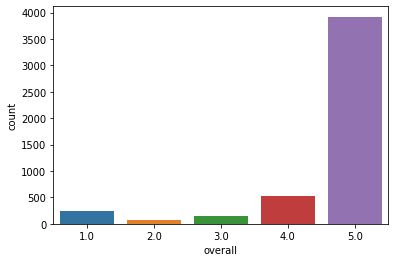

In [2]:
import pandas as pd
import math
import scipy.stats as st
# from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

df_ = pd.read_csv("../input/amazon-review-data-set/amazon_review.csv")
df = df_.copy()
df.head()
df.shape
df.columns

# Rating Dist
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)
cat_summary(df, "overall", plot=True)

In [3]:
# Mean Rating of Product
df["overall"].mean()

4.587589013224822

# Data Preparation

In [4]:
# Time-Based Weighted Average
df["reviewTime"] = pd.to_datetime(df["reviewTime"])

current_date = df["reviewTime"].max()

df["days"] = (current_date - df["reviewTime"]).dt.days

# Divide the "Days" series into quantiles and use these quantiles in the weighting calculation.
# Recent comments should have more weight
def time_based_weighted_average(dataframe, w1=28, w2=26, w3=24, w4=22):
    first, second, third = dataframe["days"].quantile([.25, .5, .75])
    return dataframe.loc[dataframe["days"] <= first, "overall"].mean() * w1 / 100 + \
           dataframe.loc[(dataframe["days"] > first) & (dataframe["days"] <= second), "overall"].mean() * w2 / 100 + \
           dataframe.loc[(dataframe["days"] > second) & (dataframe["days"] <= third), "overall"].mean() * w3 / 100 + \
           dataframe.loc[(dataframe["days"] > third), "overall"].mean() * w4 / 100

time_based_weighted_average(df)

# As can be seen from the Time-Based averages, it is observed that the overall score average of the product increases over time.
first, second, third = df["days"].quantile([.25, .5, .75])
df.loc[df["days"] <= first, "overall"].mean()
df.loc[(df["days"] > first) & (df["days"] <= second), "overall"].mean()
df.loc[(df["days"] > second) & (df["days"] <= third), "overall"].mean()
df.loc[(df["days"] > third), "overall"].mean()

# The Number of Times the Evaluation Was Found NOT Useful
df["helpful_no"] = df["total_vote"] - df["helpful_yes"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   reviewerID      4915 non-null   object        
 1   asin            4915 non-null   object        
 2   reviewerName    4914 non-null   object        
 3   helpful         4915 non-null   object        
 4   reviewText      4914 non-null   object        
 5   overall         4915 non-null   float64       
 6   summary         4915 non-null   object        
 7   unixReviewTime  4915 non-null   int64         
 8   reviewTime      4915 non-null   datetime64[ns]
 9   day_diff        4915 non-null   int64         
 10  helpful_yes     4915 non-null   int64         
 11  total_vote      4915 non-null   int64         
 12  days            4915 non-null   int64         
 13  helpful_no      4915 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(6)
me

# Sorting Reviews

In [5]:
# score_pos_neg_diff
def score_pos_neg_difference(pos, neg):
    return pos - neg

def score_average_rate(pos, neg):
    if pos + neg == 0:
        return 0
    return pos / (pos + neg)

def wilson_lower_bound(pos, neg, confidence=0.95):
    """

    Parameters
    ----------
    pos: int
        pos count
    neg: int
        neg count
    confidence: float
        confidence

    Returns
    -------
    wilson score: float
    """
    n = pos + neg
    if n == 0:
        return 0
    z = st.norm.ppf(1 - (1 - confidence) / 2)
    phat = 1.0 * pos / n
    return (phat + z * z / (2 * n) - z * math.sqrt((phat * (1 - phat) + z * z / (4 * n)) / n)) / (1 + z * z / n)

df["score_pos_neg_diff"] = df.apply(lambda x: score_pos_neg_difference(x["helpful_yes"], x["helpful_no"]), axis=1)
df["score_average_rating"] = df.apply(lambda x: score_average_rate(x["helpful_yes"], x["helpful_no"]), axis=1)
df["wilson_lower_bound"] = df.apply(lambda x: wilson_lower_bound(x["helpful_yes"], x["helpful_no"]), axis=1)

# Sorting Products by Wilson_lower_bound score
df.sort_values("wilson_lower_bound", ascending=False).head(20)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,days,helpful_no,score_pos_neg_diff,score_average_rating,wilson_lower_bound
2031,A12B7ZMXFI6IXY,B007WTAJTO,"Hyoun Kim ""Faluzure""","[1952, 2020]",[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,5.00000,UPDATED - Great w/ Galaxy S4 & Galaxy Tab 4 10...,1367366400,2013-01-05,702,1952,2020,701,68,1884,0.96634,0.95754
3449,AOEAD7DPLZE53,B007WTAJTO,NLee the Engineer,"[1428, 1505]",I have tested dozens of SDHC and micro-SDHC ca...,5.00000,Top of the class among all (budget-priced) mic...,1348617600,2012-09-26,803,1428,1505,802,77,1351,0.94884,0.93652
4212,AVBMZZAFEKO58,B007WTAJTO,SkincareCEO,"[1568, 1694]",NOTE: please read the last update (scroll to ...,1.00000,1 Star reviews - Micro SDXC card unmounts itse...,1375660800,2013-05-08,579,1568,1694,578,126,1442,0.92562,0.91214
317,A1ZQAQFYSXL5MQ,B007WTAJTO,"Amazon Customer ""Kelly""","[422, 495]","If your card gets hot enough to be painful, it...",1.00000,"Warning, read this!",1346544000,2012-02-09,1033,422,495,1032,73,349,0.85253,0.81858
4672,A2DKQQIZ793AV5,B007WTAJTO,Twister,"[45, 49]",Sandisk announcement of the first 128GB micro ...,5.00000,Super high capacity!!! Excellent price (on Am...,1394150400,2014-07-03,158,45,49,157,4,41,0.91837,0.80811
1835,A1J6VSUM80UAF8,B007WTAJTO,goconfigure,"[60, 68]",Bought from BestBuy online the day it was anno...,5.00000,I own it,1393545600,2014-02-28,283,60,68,282,8,52,0.88235,0.78465
3981,A1K91XXQ6ZEBQR,B007WTAJTO,"R. Sutton, Jr. ""RWSynergy""","[112, 139]",The last few days I have been diligently shopp...,5.00000,"Resolving confusion between ""Mobile Ultra"" and...",1350864000,2012-10-22,777,112,139,776,27,85,0.80576,0.73214
3807,AFGRMORWY2QNX,B007WTAJTO,R. Heisler,"[22, 25]",I bought this card to replace a lost 16 gig in...,3.00000,"Good buy for the money but wait, I had an issue!",1361923200,2013-02-27,649,22,25,648,3,19,0.88000,0.70044
4306,AOHXKM5URSKAB,B007WTAJTO,Stellar Eller,"[51, 65]","While I got this card as a ""deal of the day"" o...",5.00000,Awesome Card!,1339200000,2012-09-06,823,51,65,822,14,37,0.78462,0.67033
4596,A1WTQUOQ4WG9AI,B007WTAJTO,"Tom Henriksen ""Doggy Diner""","[82, 109]",Hi:I ordered two card and they arrived the nex...,1.00000,Designed incompatibility/Don't support SanDisk,1348272000,2012-09-22,807,82,109,806,27,55,0.75229,0.66359
